In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [11]:
import os
import pandas as pd
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model, update_model
from mlrun.mlutils import eval_model_v2
from cloudpickle import load
from urllib.request import urlopen

def test_classifier(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    score_method: str = 'micro',
    plots_dest: str = "",
    model_evaluator = None,
    default_model: str = "model.pkl",
    predictions_column: str = 'yscore'
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:            the function context
    :param models_path:        artifact models representing a file or a folder
    :param test_set:           test features and labels
    :param label_column:       column name for ground truth labels
    :param score_method:       for multiclass classification
    :param plots_dest:         dir for test plots
    :param model_evaluator:    NOT IMPLEMENTED: specific method to generate eval, passed in as string
                               or available in this folder
    :param predictions_column: column name for the predictions column on the resulted artifact
    """
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    try:
        model_file, model_obj, _ = get_model(models_path, suffix='.pkl')
        model_obj = load(open(model_file, "rb"))
    except Exception as a:
        raise Exception("model location likely specified")
    
    extra_data = eval_model_v2(context, xtest, ytest.values, model_obj)
    if model_obj:
        update_model(models_path, extra_data=extra_data, 
                     metrics=context.results, key_prefix='validation-')
    
    # get y_hat:
    y_hat = model_obj.predict(xtest)
    # give the prediction columns titles/headers
    if y_hat.ndim == 1 or y_hat.shape[1] == 1:
        score_names = [predictions_column]
    else:
        score_names = [f"{predictions_column}_" + str(x) for x in range(y_hat.shape[1])]

    # log the test set and its predictions (should also bind model and metadata)
    df = pd.concat([xtest, ytest, pd.DataFrame(y_hat, columns=score_names)], axis=1)
    context.log_dataset("test_set_preds", df=df, format="parquet", index=False)

In [5]:
# nuclio: end-code

### mlconfig

In [3]:
from mlrun import mlconf
import os

mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
artifact_path = mlconf.artifact_path or os.path.abspath('./')

### save

In [12]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("test_classifier", handler="test_classifier",
                      description="test a classifier using held-out or new data",
                      categories=["ml", "test"],
                      labels = {"author": "yjb", "framework": "sklearn"},
                      code_output='.')
fn.export()

[mlrun] 2020-07-13 16:17:02,696 function spec saved to path: function.yaml


## tests

In [8]:
from mlrun import mount_v3io
fn.apply(mount_v3io())

In [7]:
task_params = {
    "name" : "tasks test classifier",
    "params": {
        "label_column"  : "labels"}}

### run locally

In [8]:
TEST_REPO = "https://raw.githubusercontent.com/yjb-ds/testdata/master"
DATA_PATH  = "/User/ml2/test_set.parquet"
MODELS_PATH = "/User/artifacts/multi-models/sklearn.linear_model.LogisticRegression/model.pkl"

[mlrun] 2020-06-05 23:36:35,094 starting run tasks test classifier uid=9958837817a048dea70fe0b6780484c2  -> http://10.199.227.162:8080
[mlrun] 2020-06-05 23:36:36,015 log artifact confusion-matrix at /User/ml2/test/plots/confusion-matrix.html, size: 20273, db: N
[mlrun] 2020-06-05 23:36:36,273 log artifact feature-importances at /User/ml2/test/plots/feature-importances.html, size: 11857, db: N
[mlrun] 2020-06-05 23:36:36,393 log artifact precision-recall-multiclass at /User/ml2/test/plots/precision-recall-multiclass.html, size: 55889, db: N
[mlrun] 2020-06-05 23:36:36,523 log artifact roc-multiclass at /User/ml2/test/plots/roc-multiclass.html, size: 34633, db: N
[mlrun] 2020-06-05 23:36:36,928 log artifact test_set_preds at /User/ml2/test/test_set_preds.parquet, size: 702584, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...780484c2,0,Jun 05 23:36:35,completed,tasks test classifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-65887d7ffb-5jsn2,test_setmodels_path,label_column=labels,test-accuracy=0.649test-error=0.351auc-micro=0.8614702222222221auc-weighted=0.8482045848464809f1-score=0.5077492913608207precision_score=0.7460004969284674recall_score=0.5246800280114805,confusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 9958837817a048dea70fe0b6780484c2 --project default , !mlrun logs 9958837817a048dea70fe0b6780484c2 --project default
[mlrun] 2020-06-05 23:36:37,018 run executed, status=completed


<Figure size 432x288 with 0 Axes>

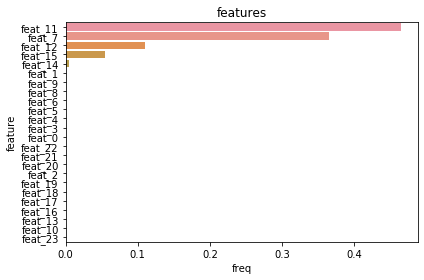

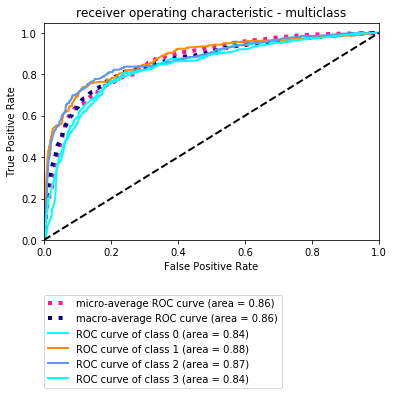

In [9]:
from mlrun import run_local, NewTask
m = 'store://default/sklearn_ensemble_AdaBoostClassifier_model#533c501fca484b3e8bf9fe8d7abbbdb5'


run = run_local(NewTask(**task_params),
                handler=test_classifier,
                inputs={"test_set":   f"{DATA_PATH}",
                        "models_path": m},
                artifact_path=artifact_path)